# FGSM attack on a basic CNN
This is an example of **fast gradient sign method** applied on MNIST dataset and refers to the model `src/baseline_convnet.py` 

In [2]:
import sys
from os.path import abspath

sys.path.append(abspath('../src/'))

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from utils import *
from baseline_convnet import BaselineConvnet
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random

In [3]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
convNet = BaselineConvnet(input_shape=input_shape, num_classes=num_classes)
classifier = convNet.load_classifier("IBM-art/mnist_cnn_original.h5")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
___

Accuracy of the trained model

In [4]:
x_test_pred = convNet.evaluate_test(classifier, x_test, y_test)


Testing infos:
x_test.shape =  (10000, 28, 28, 1) 
y_test.shape =  (10000, 10) 


Original test data.
Correctly classified: 9923
Incorrectly classified: 77
Test accuracy: 99.23%


Creating adversaries with FGSM

In [5]:
x_test_adv, x_test_adv_pred = convNet.evaluate_adversaries(classifier, x_test, y_test)


Adversarial evaluation using FGSM method.
Adversarial test data.
Correctly classified: 2417
Incorrectly classified: 7583
Adversarial accuracy: 24.17%


### FGSM adversaries
Now we show some examples of correct predictions on the test set and wrong predictions on the adversarially generated test set

test prediction		 adversarial test prediction
1 			 4
3 			 5
5 			 6
2 			 3
7 			 3


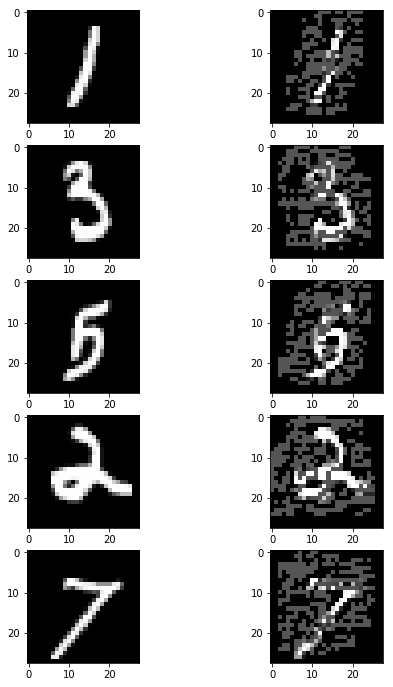

In [6]:
# one hot decoding of the labels
y_test_numeric = np.argmax(y_test, axis=1)

# idxs for correct predictions on test set, wrong on adversarial test set
#idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]
idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]

# reshape image arrays
im_test = [im.reshape(28, 28) for im in x_test]
im_test_adv = [im.reshape(28, 28) for im in x_test_adv]

# randomly sample n images
random.seed(111)
n = 5 
plot_idxs = np.random.choice(idxs, n)

f, ax = plt.subplots(n, 2, figsize=(8,12))
print("test prediction\t\t adversarial test prediction")
for i,idx in enumerate(plot_idxs):
    ax[i,0].imshow(im_test[idx], cmap='gray')
    ax[i,1].imshow(im_test_adv[idx], cmap='gray')
    print(x_test_pred[idx],"\t\t\t", x_test_adv_pred[idx])
plt.show()

## Adversarial training
Loading adversarially trained model. The attack used on this model is FGSM.

In [7]:
x_train, y_train, x_test, y_test, input_shape, num_classes = preprocess_mnist()
convNet = BaselineConvnet(input_shape=input_shape, num_classes=num_classes)
classifier = convNet.load_classifier("IBM-art/mnist_cnn_robust.h5")


Loading mnist.
x_train shape: (60000, 28, 28, 1) 
x_test shape: (10000, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
__________________________________________________________

Evaluating the adversarially FGSM trained baseline on the test set, also perturbed using FGSM, gives good accuracy.

In [8]:
x_test_adv, x_test_adv_pred = convNet.evaluate_adversaries(classifier, x_test, y_test, method='fgsm')


Adversarial evaluation using FGSM method.
Adversarial test data.
Correctly classified: 8145
Incorrectly classified: 1855
Adversarial accuracy: 81.45%


But if we evaluate the same model on test data perturbed using deepfool the results drop.

In [9]:
x_test_adv, x_test_adv_pred = convNet.evaluate_adversaries(classifier, x_test, y_test, method='deepfool')


Adversarial evaluation using DeepFool method.
Adversarial test data.
Correctly classified: 850
Incorrectly classified: 9150
Adversarial accuracy: 8.50%


### DeepFool adversaries

Now we just take a look at deepfool adversaries to notice how they generate fake unrecognizable images.

test prediction		 adversarial test prediction
5 			 8
3 			 5
0 			 8
2 			 0
4 			 6


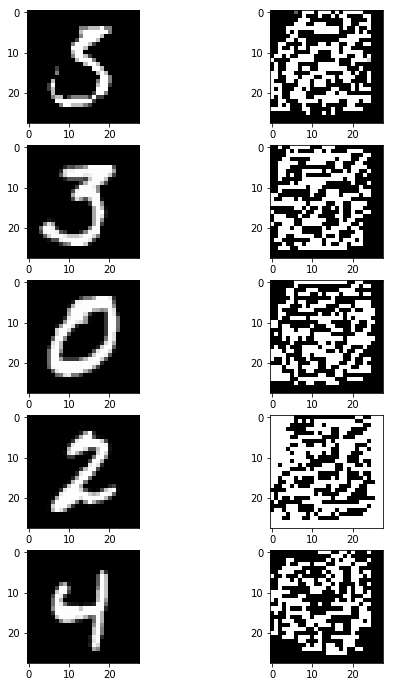

In [10]:
# one hot decoding of the labels
y_test_numeric = np.argmax(y_test, axis=1)

# idxs for correct predictions on test set, wrong on adversarial test set
#idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]
idxs = np.where((y_test_numeric == x_test_pred) & (y_test_numeric != x_test_adv_pred))[0]

# reshape image arrays
im_test = [im.reshape(28, 28) for im in x_test]
im_test_adv = [im.reshape(28, 28) for im in x_test_adv]

# randomly sample n images
random.seed(111)
n = 5 
plot_idxs = np.random.choice(idxs, n)

f, ax = plt.subplots(n, 2, figsize=(8,12))
print("test prediction\t\t adversarial test prediction")
for i,idx in enumerate(plot_idxs):
    ax[i,0].imshow(im_test[idx], cmap='gray')
    ax[i,1].imshow(im_test_adv[idx], cmap='gray')
    print(x_test_pred[idx],"\t\t\t", x_test_adv_pred[idx])
plt.show()